<a href="https://colab.research.google.com/github/tony-pitchblack/finrl-dt/blob/custom-backtesting/finrl_dt_replicate_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install stable-baselines3
!pip install finrl
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install stockstats
!pip install wrds

# Imports

In [1]:
import os
import wandb
import pandas as pd

In [2]:
os.environ["WANDB_API_KEY"] = "aee284a72205e2d6787bd3ce266c5b9aefefa42c"

PROJECT = 'finrl-dt-replicate'
ENTITY = "overfit1010"

In [62]:
RUN_ID = '32v5ws5p'

# Load models and dataset

In [23]:
# !rm -rf ./*

In [4]:
#@title Download artifacts

# Initialize the W&B API
api = wandb.Api()

# Retrieve the run
run = api.run(f"{ENTITY}/{PROJECT}/{RUN_ID}")

# Iterate over the artifacts used or logged by the run
for artifact in run.logged_artifacts():
    artifact.download(f'./{artifact.type}')

True


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   2 of 2 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   4 of 4 files downloaded.  
wandb:   2 of 2 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   8 of 8 files downloaded.  
wandb:   4 of 4 files downloaded.  
wandb:   10 of 10 files downloaded.  
wandb:   5 of 5 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [5]:
# %load_ext tensorboard
# %tensorboard --logdir ./results/

# Eval models

In [6]:
#@title imports

import sys
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.config import INDICATORS, TRAINED_MODEL_DIR

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
#@title Load data

train = pd.read_csv('./dataset/train_data.csv')
trade = pd.read_csv('./dataset/test_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [8]:
#@title Define metric functions

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days
    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [63]:
wandb.init(entity=ENTITY, project=PROJECT, id=RUN_ID, resume='must')
config = wandb.run.config
print(config.keys())

['test_years_count', 'train_years_count', 'REFERENCE_PRICE_END_DATE', 'cost_pct', 'test_end_date', 'dataset_name', 'train_start_date', 'if_using_ddpg', 'if_using_sac', 'cost_abs', 'test_start_date', 'stock_index_name', 'test_start_year', 'REFERNCE_PRICE_WINDOW_DAYS', 'train_params', 'if_using_td3', 'if_using_a2c', 'initial_amount', 'if_using_ppo']


## Eval RL-only (refactored)

In [12]:
#@title init env

def init_env(config):
    # Define environment parameters
    stock_dimension = len(trade.tic.unique())
    state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

    num_stock_shares = [0] * stock_dimension

    env_kwargs = {
        "hmax": 100,
        "initial_amount": config['initial_amount'],
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": config['cost_pct'],
        "sell_cost_pct": config['cost_pct'],
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4
    }

    # Initialize trading environment
    e_trade_gym = StockTradingEnv(
        df=trade,
        turbulence_threshold=70, risk_indicator_col='vix',
        **env_kwargs
    )

    return e_trade_gym

# e_trade_gym = init_env(config)

In [13]:
#@title get predictions

def get_predictions(e_trade_gym, config):
    # Load variables from the config
    if_using_a2c = config["if_using_a2c"]
    if_using_ddpg = config["if_using_ddpg"]
    if_using_ppo = config["if_using_ppo"]
    if_using_td3 = config["if_using_td3"]
    if_using_sac = config["if_using_sac"]

    # Ensure at least one algorithm is enabled
    if not any([if_using_a2c, if_using_ddpg, if_using_ppo, if_using_td3, if_using_sac]):
        raise ValueError("At least one algorithm must be set to True for the script to run.")

    # Load trained models
    trained_a2c = A2C.load(os.path.join(TRAINED_MODEL_DIR, "agent_a2c")) if if_using_a2c else None
    trained_ddpg = DDPG.load(os.path.join(TRAINED_MODEL_DIR, "agent_ddpg")) if if_using_ddpg else None
    trained_ppo = PPO.load(os.path.join(TRAINED_MODEL_DIR, "agent_ppo")) if if_using_ppo else None
    trained_td3 = TD3.load(os.path.join(TRAINED_MODEL_DIR, "agent_td3")) if if_using_td3 else None
    trained_sac = SAC.load(os.path.join(TRAINED_MODEL_DIR, "agent_sac")) if if_using_sac else None

    # Reset the result DataFrame
    result = pd.DataFrame()

    # Predict and store results for all enabled algorithms
    for algo_name, trained_model, is_enabled in [
        ("A2C", trained_a2c, if_using_a2c),
        ("DDPG", trained_ddpg, if_using_ddpg),
        ("PPO", trained_ppo, if_using_ppo),
        ("TD3", trained_td3, if_using_td3),
        ("SAC", trained_sac, if_using_sac)
    ]:
        if is_enabled:
            df_account_value, df_actions = DRLAgent.DRL_prediction(
                model=trained_model, environment=e_trade_gym
            )
            df_result = df_account_value.set_index(df_account_value.columns[0])
            df_result.columns = [f"{algo_name}_{col}" for col in df_result.columns]
            result = pd.merge(result, df_result, how="outer", left_index=True, right_index=True)

    # Create a dictionary with the mapping of old columns to model names
    rename_dict = {
        'A2C_account_value': 'A2C',
        'DDPG_account_value': 'DDPG',
        'PPO_account_value': 'PPO',
        'TD3_account_value': 'TD3',
        'SAC_account_value': 'SAC'
    }

    # Rename columns using the dictionary and ignore errors for columns not in the dictionary
    result = result.rename(columns=rename_dict, errors='ignore')
    result.index = pd.to_datetime(result.index)
    return result

# result = get_predictions(e_trade_gym, config)
# result

In [131]:
#@title add DIJA for test period

def add_djia_test(result):
    # Define test period
    TEST_START_DATE = trade['date'].iloc[0]
    TEST_END_DATE = trade['date'].iloc[-1]

    # Fetch DJIA data for the test period
    df_dji = YahooDownloader(
        start_date=TEST_START_DATE,
        end_date=TEST_END_DATE,
        ticker_list=['dji']
    ).fetch_data()
    df_dji['date'] = pd.to_datetime(df_dji['date'])

    # Merge DJIA data
    df_dji = df_dji[['date','close']]
    fst_day = df_dji['close'].iloc[0]
    dji = pd.DataFrame({
        'DJIA': df_dji['close'].div(fst_day).mul(config['initial_amount']).values
        # 'DJIA': df_dji['close'].div(fst_day).values
    }, index=df_dji['date'])

    # Merge DJIA data using inner join to ensure alignment
    result = pd.merge(result, dji, how='inner', left_index=True, right_index=True).fillna(method='bfill')

    return result

# result = add_djia_test(result)
# result

In [67]:
#@title Calculate metrics for individual algorithms (w/annualized returns)

def calculate_metrics(result):
    label_mapping = {
        # 'DT_LoRA_GPT2': 'DT-LoRA-GPT2',
        # 'DT_LoRA_Random_Weight_GPT2': 'DT-LoRA-Random-GPT2',
        # 'CQL': 'Conservative Q-Learning',
        # 'IQL': 'Implicit Q-Learning',
        # 'BC': 'Behavior Cloning',
        'A2C': 'A2C',
        'DDPG': 'DDPG',
        'PPO': 'PPO',
        'TD3': 'TD3',
        'SAC': 'SAC',
        'DJIA': 'Dow Jones Index'
    }

    metrics_dict = {
        'Method': [],
        'Cumulative Return Mean (%)': [],
        # 'Cumulative Return Std (%)': [],
        'Annualized Return Mean (%)': [],
        # 'Annualized Return Std (%)': [],
        'MDD Mean (%)': [],
        'MDD Std (%)': [],
        'Sharpe Ratio Mean': [],
        'Sharpe Ratio Std': []
    }

    experiment_stats = {}
    individual_algos = ['A2C', 'DDPG', 'TD3', 'SAC', 'PPO']
    for algo in individual_algos:
        if algo in result.columns:
            # Check if this algorithm is already part of experiment_groups
            if label_mapping.get(algo, algo) in experiment_stats:
                print(f"Info: '{algo}' is already included in experiment groups. Skipping individual plotting to avoid duplication.")
                continue  # Skip to prevent duplicate plotting

            asset_values = result[algo].dropna()
            if asset_values.empty:
                print(f"Warning: No valid asset values for individual algorithm '{algo}'. Skipping metrics calculation.")
                continue

            cum_ret = (asset_values.iloc[-1] - asset_values.iloc[0]) / asset_values.iloc[0] * 100

            # Handle potential division by zero or invalid calculations
            if np.isinf(cum_ret) or np.isnan(cum_ret):
                cum_ret = np.nan

            # Calculate annualized return
            num_days = (asset_values.index[-1] - asset_values.index[0]).days
            ann_ret = ( (1 + cum_ret / 100) ** (365 / num_days) - 1 ) * 100

            # MDD
            mdd = calculate_mdd(asset_values)
            # Sharpe Ratio
            sharpe = calculate_sharpe_ratio(asset_values)
            # Append to metrics_dict with mapped label
            mapped_algo = label_mapping.get(algo, algo)
            metrics_dict['Method'].append(mapped_algo)
            metrics_dict['Cumulative Return Mean (%)'].append(cum_ret)
            # metrics_dict['Cumulative Return Std (%)'].append(0.00)  # Single run, std is 0
            metrics_dict['Annualized Return Mean (%)'].append(ann_ret)
            # metrics_dict['Annualized Return Std (%)'].append(0.00)  # Single run, std is 0
            metrics_dict['MDD Mean (%)'].append(mdd)
            metrics_dict['MDD Std (%)'].append(0.00)  # Single run, std is 0
            metrics_dict['Sharpe Ratio Mean'].append(sharpe)
            metrics_dict['Sharpe Ratio Std'].append(0.00)  # Single run, std is 0

            # Store in experiment_stats for plotting
            experiment_stats[mapped_algo] = {'mean': asset_values, 'std': pd.Series([0]*len(asset_values), index=asset_values.index)}

    # Convert metrics_dict to DataFrame
    metrics_df = pd.DataFrame(metrics_dict)

    # Drop any rows with NaN metrics to ensure clean tables
    metrics_df = metrics_df.dropna(subset=['Cumulative Return Mean (%)', 'Annualized Return Mean (%)', 'MDD Mean (%)', 'Sharpe Ratio Mean'])

    # Create summary DataFrame with formatted strings
    metrics_summary_df = metrics_df.copy()
    metrics_summary_df['Cumulative Return (%)'] = metrics_df['Cumulative Return Mean (%)'].round(2).astype(str) \
        #  + " ± " + metrics_df['Cumulative Return Std (%)'].round(2).astype(str)
    metrics_summary_df['Annualized Return (%)'] = metrics_df['Annualized Return Mean (%)'].round(2).astype(str) \
        #  + " ± " + metrics_df['Annualized Return Std (%)'].round(2).astype(str)
    metrics_summary_df['MDD (%)'] = metrics_df['MDD Mean (%)'].round(2).astype(str) \
        #  + " ± " + metrics_df['MDD Std (%)'].round(2).astype(str)
    metrics_summary_df['Sharpe Ratio'] = metrics_df['Sharpe Ratio Mean'].round(2).astype(str) \
        #  + " ± " + metrics_df['Sharpe Ratio Std'].round(2).astype(str)
    metrics_summary_df = metrics_summary_df[['Method', 'Cumulative Return (%)', 'Annualized Return (%)', 'MDD (%)', 'Sharpe Ratio']]

    return metrics_df, metrics_summary_df, experiment_stats

# metrics_df, metrics_summary_df, experiment_stats = calculate_metrics(result)

In [16]:
#@title Print the comparison table (w/annualized returns)

def print_comparison_table(metrics_summary_df, metrics_df):
    print(f"\n=== Metrics Comparison ===")
    print(metrics_summary_df.to_string(index=False))
    print("\n")

    # Create separate DataFrames for rankings
    ranking_cum_ret = metrics_df[['Method', 'Cumulative Return Mean (%)']].copy()
    ranking_cum_ret = ranking_cum_ret.sort_values(by='Cumulative Return Mean (%)', ascending=False)

    ranking_annualized_ret = metrics_df[['Method', 'Annualized Return Mean (%)']].copy()
    ranking_annualized_ret = ranking_annualized_ret.sort_values(by='Annualized Return Mean (%)', ascending=False)

    ranking_mdd = metrics_df[['Method', 'MDD Mean (%)']].copy()
    ranking_mdd = ranking_mdd.sort_values(by='MDD Mean (%)', ascending=False)  # Lower abs(MDD) is better

    ranking_sharpe = metrics_df[['Method', 'Sharpe Ratio Mean']].copy()
    ranking_sharpe = ranking_sharpe.sort_values(by='Sharpe Ratio Mean', ascending=False)

    # Print rankings
    print(f"=== Rankings ===")

    print("\nCumulative Return (%):")
    for idx, row in ranking_cum_ret.iterrows():
        print(f"{row['Method']}: {row['Cumulative Return Mean (%)']:.2f}%")

    print("\nAnnualized Return (%):")
    for idx, row in ranking_annualized_ret.iterrows():
        print(f"{row['Method']}: {row['Annualized Return Mean (%)']:.2f}%")

    print("\nMaximum Drawdown (MDD %) [Lower absolute values is Better]:")
    for idx, row in ranking_mdd.iterrows():
        print(f"{row['Method']}: {row['MDD Mean (%)']:.2f}%")

    print("\nSharpe Ratio [Higher is Better]:")
    for idx, row in ranking_sharpe.iterrows():
        print(f"{row['Method']}: {row['Sharpe Ratio Mean']:.2f}")

    print("\n")

    # # Debugging: Check if all means align with result.index
    # for exp_name, stats in experiment_stats.items():
    #     mean_length = len(stats['mean'])
    #     result_length = len(result.index)
    #     if mean_length != result_length:
    #         print(f"Warning: Mean length for '{exp_name}' ({mean_length}) does not match result index length ({result_length}). Reindexing.")
    #         experiment_stats[exp_name]['mean'] = stats['mean'].reindex(result.index).fillna(method='ffill')
    #         experiment_stats[exp_name]['std'] = stats['std'].reindex(result.index).fillna(0)

# print_comparison_table(metrics_summary_df, metrics_df)

In [59]:
#@title log_test_metrics

def log_test_metrics(metrics_summary_df):
    # Calculate maximum values for each metric
    max_cum_return = metrics_summary_df['Cumulative Return (%)'].max()
    max_ann_return = metrics_summary_df['Annualized Return (%)'].max()
    max_mdd = metrics_summary_df['MDD (%)'].max()
    max_sharpe_ratio = metrics_summary_df['Sharpe Ratio'].max()

    # Log metrics for each model and maximum values
    for _, row in metrics_summary_df.iterrows():
        model_name = row['Method'].lower()  # Convert the model name to lowercase

        # Log per-model metrics
        wandb.run.log({
            'test': {
                f'cum_return/{model_name}': row['Cumulative Return (%)'],
                f'ann_return/{model_name}': row['Annualized Return (%)'],
                f'mdd/{model_name}': row['MDD (%)'],
                f'sharpe_ratio/{model_name}': row['Sharpe Ratio']
            }
        })

    # Log maximum values across models
    wandb.run.log({
        'test': {
            'max_cum_return': max_cum_return,
            'max_ann_return': max_ann_return,
            'max_mdd': max_mdd,
            'max_sharpe_ratio': max_sharpe_ratio
        }
    })

# log_test_metrics(metrics_summary_df)

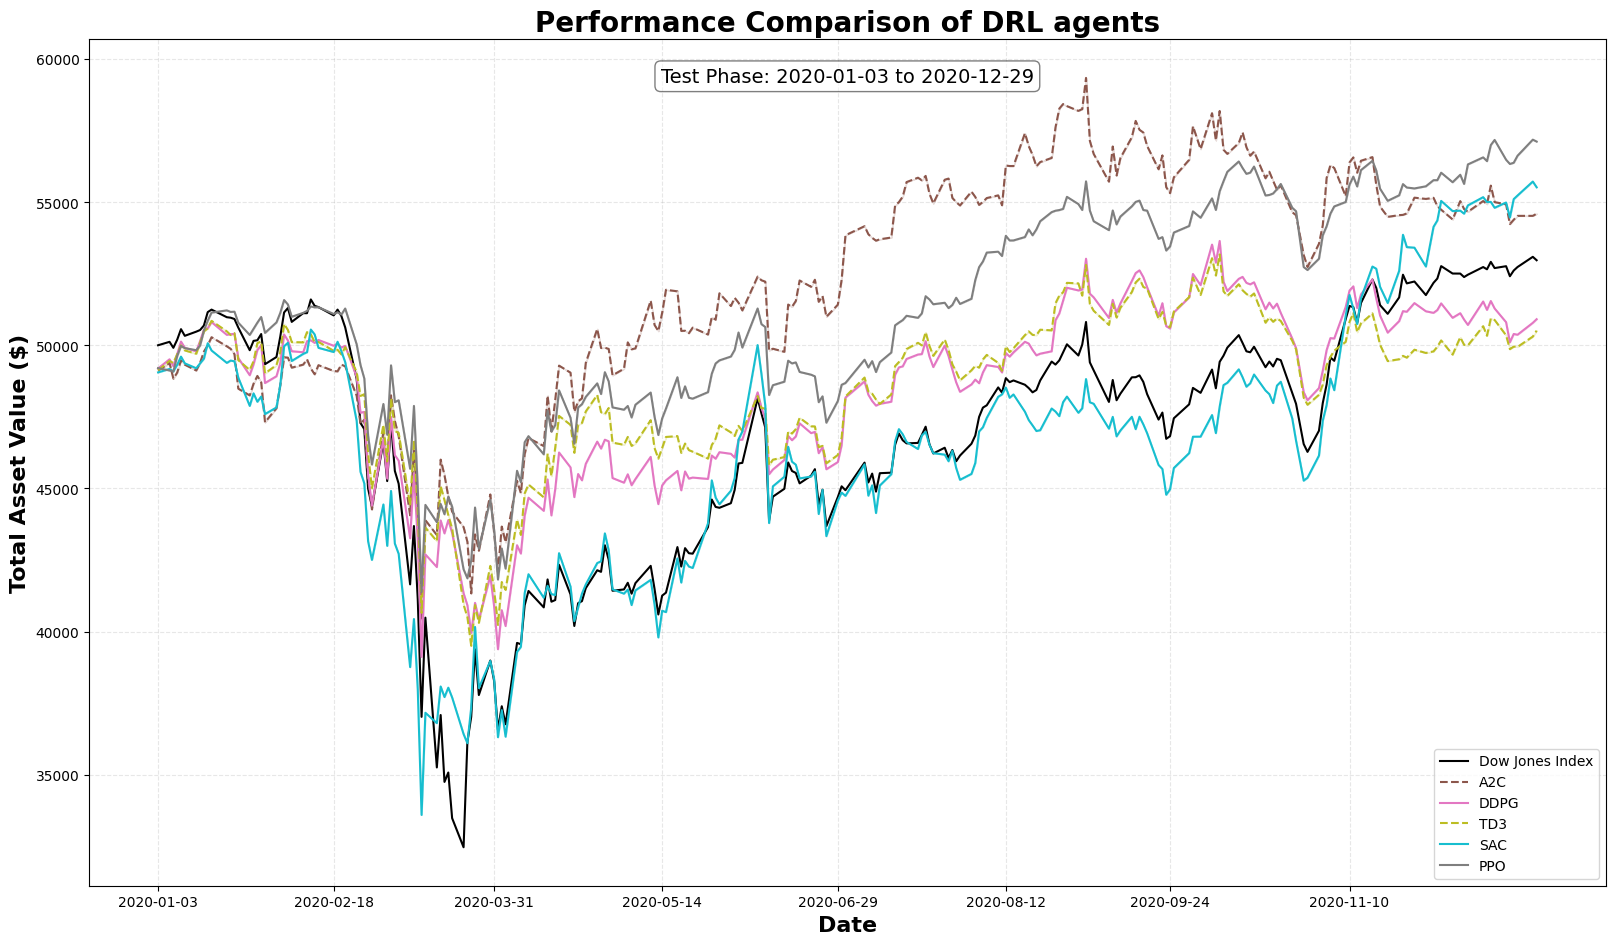

In [134]:
#@title plot results
%matplotlib inline

def plot_results(result, experiment_stats):
    # Plotting section
    fig = plt.figure(figsize=(16, 9))  # Increased figure size for better readability
    method_styles = {
        # 'CQL': {'color': '#1f77b4', 'linestyle': '-'},           # Blue solid
        # 'IQL': {'color': '#ff7f0e', 'linestyle': '--'},          # Orange dashed
        # 'BC': {'color': '#2ca02c', 'linestyle': '-.'},           # Green dash-dot
        # 'DT LoRA GPT2': {'color': '#d62728', 'linestyle': ':'},  # Red dotted
        # 'DT LoRA Random Weight GPT2': {'color': '#9467bd', 'linestyle': '-'},  # Purple solid
        'A2C': {'color': '#8c564b', 'linestyle': '--'},          # Brown dashed
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},          # Pink solid
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},           # Gray solid
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},          # Olive dashed
        'SAC': {'color': '#17becf', 'linestyle': '-'},           # Cyan solid
        'DJIA': {'color': '#000000', 'linestyle': '-'},          # Black solid
        # Add more methods here if needed
    }
    # Plot DJIA
    plt.plot(result.index, result['DJIA'], label="Dow Jones Index", linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    # Define color palette and line styles
    color_palette = plt.get_cmap('tab10').colors  # Colorblind-friendly palette
    line_styles = ['-', '--', '-.', ':']  # Different line styles

    # Plot experiment groups
    for idx, (exp_name, stats) in enumerate(experiment_stats.items()):
        min_date = stats['mean'].index.min()
        max_date = stats['mean'].index.max()

        mean = stats['mean']
        std = stats['std']

        # Ensure mean and std are aligned with result.index
        mean = mean.reindex(result.index).fillna(method='ffill')
        std = std.reindex(result.index).fillna(0)

        # Assign colors and line styles
        color = color_palette[idx % len(color_palette)]
        linestyle = line_styles[idx % len(line_styles)]

        def exp_name_formatter(exp_name):
            exp_names = exp_name.split('_')
            if len(exp_names) == 1:
                return exp_name
            elif len(exp_names) == 2:
                return exp_names[1].upper()
            elif len(exp_names) == 3:
                return None
            elif len(exp_names) == 4:
                return exp_names[1].upper() + ' LoRA ' + 'GPT2'
            elif len(exp_names) == 6:
                return exp_names[1].upper() + ' LoRA ' + 'Random Weight ' + 'GPT2'
            else:
                return exp_name

        # Plot mean
        line, = plt.plot(
            result.index,
            mean,
            label=exp_name_formatter(exp_name),
            linestyle=method_styles[exp_name_formatter(exp_name)]['linestyle'],
            color=method_styles[exp_name_formatter(exp_name)]['color']
        )

        # Plot error bands (mean ± 1 std)
        plt.fill_between(
            result.index,
            mean - std,
            mean + std,
            color=method_styles[exp_name_formatter(exp_name)]['color'],
            alpha=0.2
        )

    # Enhance layout and aesthetics
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.3)

    # Set title and labels with enhanced formatting
    plt.title(f"Performance Comparison of DRL agents", fontsize=20, fontweight='bold')
    plt.xlabel("Date", fontsize=16, fontweight='bold')
    plt.ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')
    plt.xticks(result.index[0::30])

    # Add 'Test Phase' annotation with date range
    plt.text(0.5, 0.95, f'Test Phase: {min_date.date()} to {max_date.date()}',
    transform=plt.gca().transAxes, fontsize=14, ha='center',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5))

    plt.legend(loc='lower right')
    return fig

# fig = plot_results(result, experiment_stats)
# plt.show()

In [ ]:
#@title log_plot_as_artifact

def log_plot_as_artifact(fig, artifact_name, artifact_type="plot", filename="plot.png"):
    """
    Save a Matplotlib figure and log it as a W&B artifact.

    Parameters:
        fig (matplotlib.figure.Figure): The Matplotlib figure to save and log.
        artifact_name (str): The name of the W&B artifact.
        artifact_type (str): The type of the artifact (default is "plot").
        filename (str): The filename to save the plot as (default is "plot.png").
    """
    # Save the figure to a file
    fig.savefig(filename)
    plt.close(fig)  # Close the figure to free up memory

    # Create and log the W&B artifact
    artifact = wandb.Artifact(artifact_name, type=artifact_type)
    artifact.add_file(filename)
    wandb.log_artifact(artifact)

# log_plot_as_artifact(fig, artifact_name="performance_comparison_DRL_agents", artifact_type="plot", filename="performance_comparison_DRL_agents.png")

In [141]:
#@title run_prediction_and_log_metrics

def run_prediction_and_log_metrics(run_id):
    with wandb.init(project=PROJECT, entity=ENTITY, id=run_id, resume='must'):
        config = wandb.run.config

        e_trade_gym = init_env(config)
        result = get_predictions(e_trade_gym, config)
        result = add_djia_test(result)
        metrics_df, metrics_summary_df, experiment_stats = calculate_metrics(result)
        log_test_metrics(metrics_summary_df)
        fig = plot_results(result, experiment_stats)
        log_plot_as_artifact(fig, artifact_name="performance_comparison_DRL_agents", artifact_type="plot", filename="performance_comparison_DRL_agents.png")

# run_prediction_and_log_metrics(RUN_ID)

In [61]:
from tqdm.notebook import tqdm

api = wandb.Api()
sweep_id = 'mkhq30nx'
sweep = api.sweep(f'{ENTITY}/{PROJECT}/{sweep_id}')

for run in tqdm(sweep.runs):
    run_prediction_and_log_metrics(run.id)
    pass

True


  0%|          | 0/1 [00:00<?, ?it/s]

Stock Dimension: 29, State Space: 291


[*********************100%***********************]  1 of 1 completed

hit end!
Shape of DataFrame:  (240, 8)


max_sharpe_ratio,-3.85382
max_sharpe_ratio_model,a2c
sharpe_ratio/a2c,-3.85382
